In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DAmethod.particle_filter import BootstrapPF
from dynamicalsystems.anharmonic_oscillator import NonLinearOscillatorModel
%matplotlib inline

In [7]:
H = np.atleast_2d([0, 1])
R = np.atleast_2d([49])
period_assim = 50
Nparticles = 250
assimilation_steps=300


PF = BootstrapPF(state_dimension=2, Nparticles=Nparticles, R=R)
PF.H = H
PF.set_forwardmodel(
    lambda x: NonLinearOscillatorModel.integrate(0, x, period_assim)[1][:, -1]
)
truth = NonLinearOscillatorModel()
truth.set_initial_state(0, np.array([0, 1]))

def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.normal(size=2) * np.sqrt(float(R))
    return truth.t[-1], y

PF.generate_particles(
    mean=np.array([0, 1]), cov=np.array([[2, 0], [0, 2]])
)



In [8]:
dPF = PF.run(assimilation_steps, generate_observations, full_obs=True, ESS_lim=None)

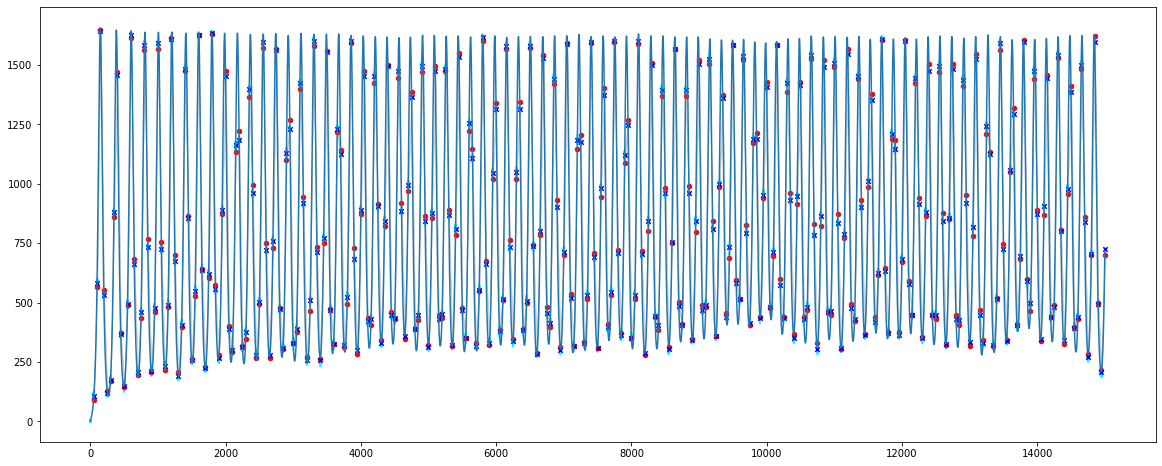

In [9]:
est_ = np.array(dPF["estimates"])[:, 0]
obs_ = np.array(dPF["observations"])[:, 0]
wei_ = np.array(dPF["weights"])
plt.figure(figsize=(20, 8))
for i in range(assimilation_steps):
    plt.scatter(
        period_assim * (i) * np.ones(Nparticles),
        np.asarray(dPF["particles"])[i, 1, :],
        marker="o",
        c="cyan",
        s=300 * wei_[i, :],
    )
v_ = [
    PF.weighted_moments(
        np.array(dPF["particles"])[i, :, :],
        np.array(dPF["weights"])[i, :],
    )[1]
    for i in range(assimilation_steps)
]
std = np.sqrt(np.array(v_)[:, 1])
plt.fill_between(
    dPF["time"],
    np.squeeze(PF.H(est_.T) + 2 * std),
    np.squeeze(PF.H(est_.T) - 2 * std),
    color="gray",
    alpha=0.3,
)
plt.scatter(dPF["time"], obs_, marker="o", c="red", s=20)
plt.scatter(dPF["time"], PF.H(est_.T), marker="x", color="blue", s=20)
plt.plot(truth.state_vector[1, :])
plt.show()
